In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import csv
import svgwrite


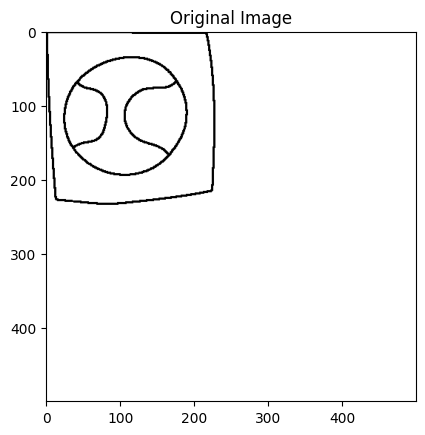

In [43]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_paths(paths, image_size=(500, 500)):
    image = np.ones((*image_size, 3), dtype=np.uint8) * 255
    for path in paths:
        for segment in path:
            for i in range(len(segment) - 1):
                pt1 = tuple(map(int, segment[i]))
                pt2 = tuple(map(int, segment[i + 1]))
                cv2.line(image, pt1, pt2, (0, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.show()
    return image

csv_path = 'problems/frag0.csv'
paths = read_csv(csv_path)
image = plot_paths(paths)


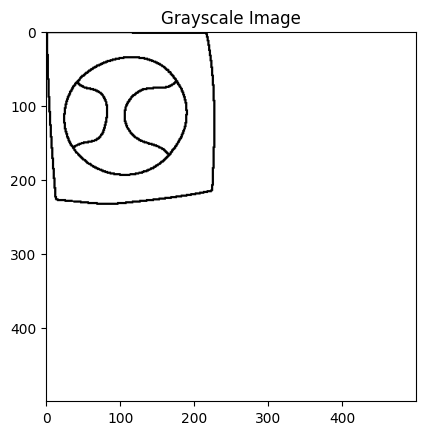

In [44]:
def convert_to_grayscale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

gray_image = convert_to_grayscale(image)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.show()


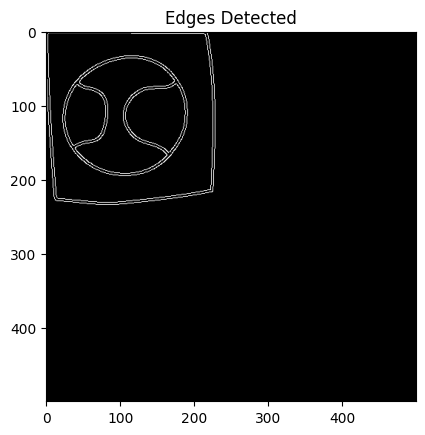

In [45]:
def apply_canny_edge_detection(gray_image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)
    return edges

edges = apply_canny_edge_detection(gray_image)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.show()


In [46]:
def find_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = find_contours(edges)


Contour Area: 48195.5, Bounding Box: (2, 2, 224, 230)
Contour Area: 3.5, Bounding Box: (0, 0, 229, 235)
Contour Area: 0.0, Bounding Box: (0, 0, 1, 1)


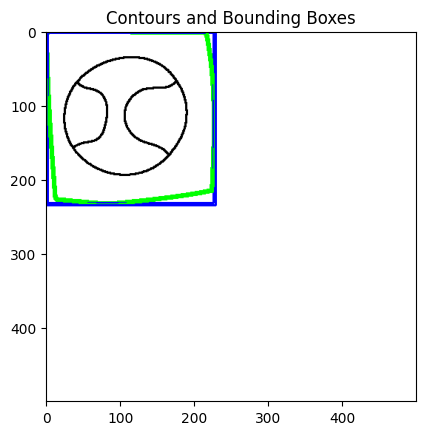

In [47]:
def draw_contours(image, contours):
    contour_image = image.copy()
    for contour in contours:
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(contour_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        print(f'Contour Area: {area}, Bounding Box: {(x, y, w, h)}')
    return contour_image

contour_image = draw_contours(image, contours)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours and Bounding Boxes')
plt.show()


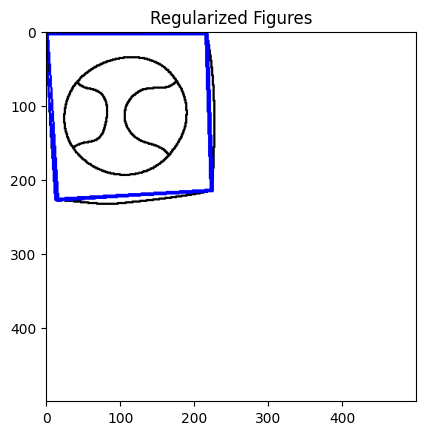

In [48]:
def approximate_contours(contours, epsilon_factor=0.02):
    approx_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_contours.append(approx)
    return approx_contours

approx_contours = approximate_contours(contours)
regularized_image = image.copy()
for contour in approx_contours:
    cv2.drawContours(regularized_image, [contour], -1, (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(regularized_image, cv2.COLOR_BGR2RGB))
plt.title('Regularized Figures')
plt.show()


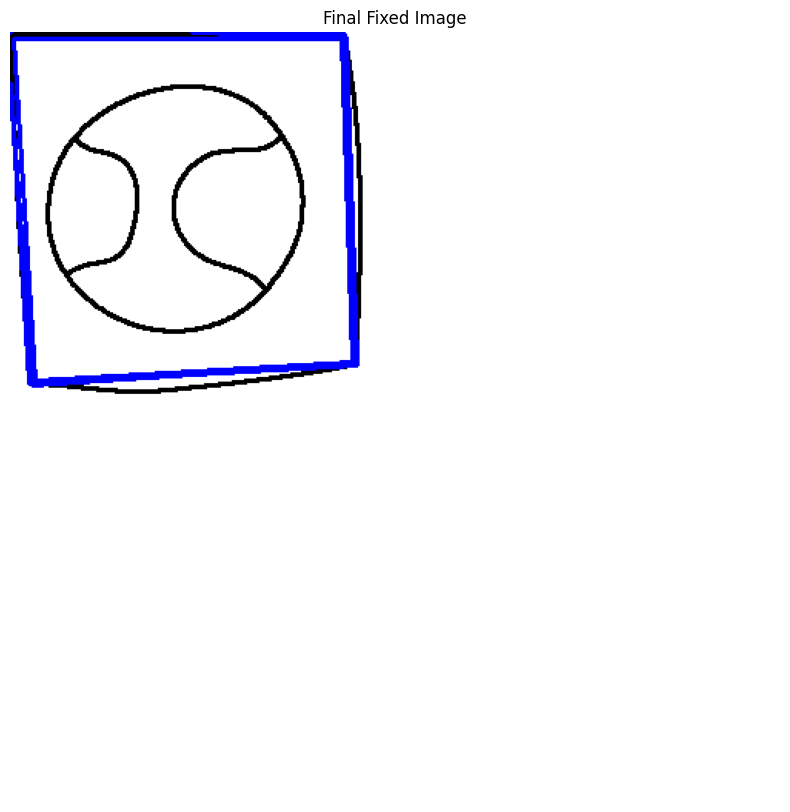

Fixed image saved as output\fixed_image.png
Contours properties saved as output\contours_properties.csv
Image saved as SVG at output\fixed_image.svg


In [49]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)


png_path = os.path.join(output_dir, 'fixed_image.png')
cv2.imwrite(png_path, cv2.cvtColor(regularized_image, cv2.COLOR_RGB2BGR))

csv_path = os.path.join(output_dir, 'contours_properties.csv')
with open(csv_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Contour', 'Area', 'Bounding Box'])
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        csv_writer.writerow([i, area, f'({x}, {y}, {w}, {h})'])

def save_image_as_svg(image, filename):
    dwg = svgwrite.Drawing(filename, profile='tiny', size=(image.shape[1], image.shape[0]))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for y in range(gray_image.shape[0]):
        for x in range(gray_image.shape[1]):
            color = gray_image[y, x]
            if color < 255:
                dwg.add(dwg.rect((x, y), (1, 1), fill=svgwrite.rgb(color, color, color, '%')))
    
    dwg.save()

svg_path = os.path.join(output_dir, 'fixed_image.svg')
save_image_as_svg(regularized_image, svg_path)
plt.figure(figsize=(10, 10))  
plt.imshow(cv2.cvtColor(regularized_image, cv2.COLOR_BGR2RGB))
plt.title('Final Fixed Image')
plt.axis('off') 
plt.gca().set_aspect('equal', adjustable='box') 
plt.show()

print(f'Fixed image saved as {png_path}')
print(f'Contours properties saved as {csv_path}')
print(f'Image saved as SVG at {svg_path}')

